In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
%env CUDA_LAUNCH_BLOCKING = 1 
%env TORCH_USE_CUDA_DSA = 1
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

env: CUDA_LAUNCH_BLOCKING=1
env: TORCH_USE_CUDA_DSA=1


device(type='cuda')

# Data prep

In [3]:
ANNOT_FIXED = "../data/processed/AnnotHepar.csv"
df = pd.read_csv(ANNOT_FIXED, index_col=0)
df

,TreatmentType,Image,TreatmentSubType
0,HFD10X,Hepar-HFDA151X10-2_T00.tiff,HFDA15
1,HFD10X,Hepar-HFDA151X10-2_T01.tiff,HFDA15
2,HFD10X,Hepar-HFDA153X10-1_T11.tiff,HFDA15
3,HFD10X,Hepar-HFDA151X10-2_T11.tiff,HFDA15
4,HFD10X,Hepar-HFDA151X10-1_T00.tiff,HFDA15
...,...,...,...
21163,ND400X,HeparNDA25.2400x2_T89.tiff,NDA25
21164,ND400X,HeparNDA25.1400x_T63.tiff,NDA25
21165,ND400X,HeparNDA25.3400x1_T82.tiff,NDA25
21166,ND400X,HeparNDA25.3400x2_T68.tiff,NDA25


In [4]:
target = pd.get_dummies(df.TreatmentSubType, dtype=float)
annot = pd.concat([df['Image'], target], axis=1)

In [5]:
annot['Image'] = annot['Image'].apply(lambda x: x[:-4]+"png")

In [6]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

Label kontrol dan non

In [7]:
annot

,Image,HFDA0,HFDA10,HFDA15,HFDA20,HFDA25,HFDA5,HFDK+,HFDNaCl,HFDSimvastatin,ND,NDA0,NDA25,NDA5,normal
0,Hepar-HFDA151X10-2_T00.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hepar-HFDA151X10-2_T01.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Hepar-HFDA153X10-1_T11.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Hepar-HFDA151X10-2_T11.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Hepar-HFDA151X10-1_T00.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21163,HeparNDA25.2400x2_T89.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21164,HeparNDA25.1400x_T63.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21165,HeparNDA25.3400x1_T82.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21166,HeparNDA25.3400x2_T68.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
annot.to_csv('../data/processed/OHEhepar.csv', index=False)

In [9]:
classes = list(df.TreatmentSubType.unique())
classes

['HFDA15',
 'HFDA5',
 'HFDA10',
 'HFDA25',
 'HFDSimvastatin',
 'HFDA20',
 'HFDA0',
 'HFDK+',
 'HFDNaCl',
 'normal',
 'NDA5',
 'ND',
 'NDA0',
 'NDA25']

In [10]:
split = annot.copy()

In [11]:
from sklearn.model_selection import train_test_split
split['classes'] = split.apply((lambda x: x[classes].argmax()), axis=1)
train, test = train_test_split(split, test_size=0.20, random_state=1024, stratify=split['classes'])

In [12]:
print(f"Number of train images: {len(train)}")
print(f"Number of validation images: {len(test)}")

Number of train images: 16934
Number of validation images: 4234


In [13]:
!pwd

/home/dzakirm/Research/Histopathology/histopathology/notebooks


In [14]:
print("Creating Train Data")
train.to_csv("../data/processed/train.csv", index=False)

print("Creating Test Data")
test.to_csv("../data/processed/test.csv", index=False)

Creating Train Data
Creating Test Data


In [15]:
annot.to_csv("../data/processed/annot.csv", index=False)

In [16]:
torch.from_numpy(annot.iloc[:, 1:].to_numpy()).type(torch.float32)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

In [66]:
import torchvision
import torchvision.transforms.v2
def create_dataset(subset: str, image_path: str = '../data/processed/HeparUnifiedPNG/' ):
    df = pd.read_csv(f'../data/processed/{subset}.csv')
    X = df['Image'].apply(lambda x: image_path + x).astype(str).to_list()
    y = torch.from_numpy(df.iloc[:, -1].to_numpy())
    return X, y


In [67]:
df['TreatmentSubType'].nunique()

14

In [68]:
!pwd

/home/dzakirm/Research/Histopathology/histopathology/notebooks


In [69]:
X, y = create_dataset('train')

In [70]:
y

tensor([1, 3, 3,  ..., 3, 3, 5])

In [86]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, X: torch.tensor, y: torch.tensor, device):
        super().__init__()
        
        self.X = X
        self.y = y
        
    def __getitem__(self, i: int):
        image = torchvision.io.read_image(self.X[i])
        image = image.type(torch.float32) / 255
        return image.to(device), self.y[i].to(device)
    
    def __len__(self):
        return len(self.X)


In [88]:
train_ds = ImageDataset(*create_dataset('train'), device)
test_ds = ImageDataset(*create_dataset('test'), device)

In [90]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8)

In [91]:
x, y = next(iter(train_dl))
print(f"Shape of train input: {x.shape}, Shape of train output: {y.shape}")
x, y = next(iter(test_dl))
print(f"Shape of test input: {x.shape}, Shape of test output: {y.shape}")

Shape of train input: torch.Size([8, 3, 128, 128]), Shape of train output: torch.Size([8])
Shape of test input: torch.Size([8, 3, 128, 128]), Shape of test output: torch.Size([8])


<Axes: >

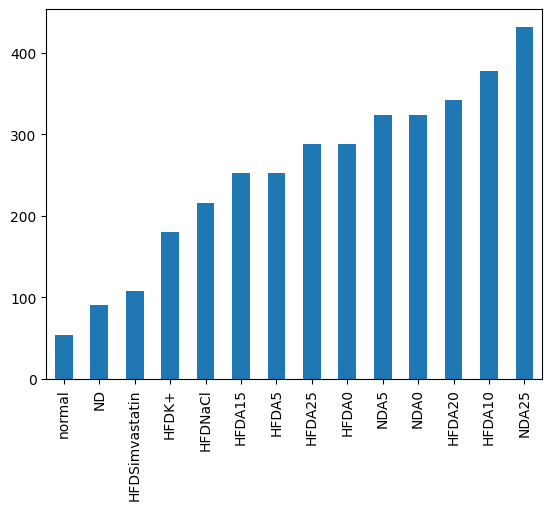

In [75]:
num_classes = (annot[classes].sum(axis=0).astype(int)//6).sort_values()
num_classes.plot(kind='bar')

In [43]:
import torchvision.transforms.functional as F
import numpy as np

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    plt.figure(figsize=(12, 8))
    npimage = imgs.numpy(force=True).transpose((1, 2, 0))
    plt.imshow(npimage)
    plt.show()
    # if not isinstance(imgs, list):
    #     imgs = [imgs]
    # fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    # for i, img in enumerate(imgs):
    #     img = img.detach()
    #     img = F.to_pil_image(img)
    #     axs[0, i].imshow(np.asarray(img))
    #     axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


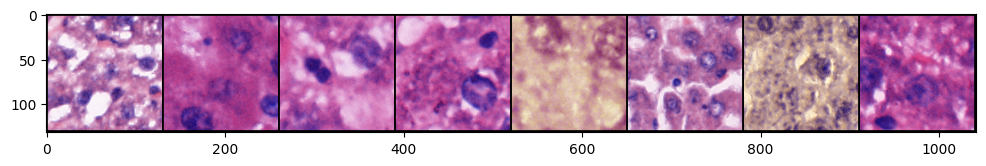

In [44]:
from torchvision.utils import make_grid
from torchvision.io import read_image

grid = make_grid(x)
show(grid)